<center> 
    <h1> Personality Trait Classification on Twitter  </h1>
    <h4> <i> Author: Pavan Kumar K N, Marina L. Gavrilova </i>  </h4>
 </center>

In [3]:
#
# * File:    classic_persona.py
# *
# * Author1:  Pavan Kumar K N (pavankumar.karkekopp@ucalgary.ca)
# * Date:     20th May 2019
# * Summary of File:
# * Explore mbti_1.csv file acquired from https://www.kaggle.com/datasnaek/mbti-type
# * Apply state-of-the-art reported publicly
# * Build classifier model that is better using machine learning techniques

#Just making sure the right environment is running this script
import sys
sys.executable


'C:\\ProgramData\\Anaconda3\\python.exe'

In [4]:
#Read Data
import numpy as np
import pandas as pd
import sklearn
import re
import pickle

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

from numpy import loadtxt
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [5]:
#Read the dataset
mbti_data = pd.read_csv("data/mbti_1.csv")

In [6]:
#Print first 5 entries in the dataset
mbti_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [7]:
raw_posts = mbti_data.posts.values

In [9]:
#Split posts by the delimiter, which is ||| as we can see in row 0 and 4 above
filtered_posts = [p.split("|||") for p in raw_posts]
#Example of two tweets from row 0
for i in range(5):
    print("Tweet #{}:   {}".format(i+1,filtered_posts[0][i]))


Tweet #1:   'http://www.youtube.com/watch?v=qsXHcwe3krw
Tweet #2:   http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg
Tweet #3:   enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks
Tweet #4:   What has been the most life-changing experience in your life?
Tweet #5:   http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.


#### MBTI Types Distribution in Data

In [13]:
count_types = mbti_data['type'].value_counts()
count_types = round(count_types/sum(count_types),4) * 100

In [14]:
count_types

INFP    21.12
INFJ    16.95
INTP    15.03
INTJ    12.58
ENTP     7.90
ENFP     7.78
ISTP     3.88
ISFP     3.12
ENTJ     2.66
ISTJ     2.36
ENFJ     2.19
ISFJ     1.91
ESTP     1.03
ESFP     0.55
ESFJ     0.48
ESTJ     0.45
Name: type, dtype: float64

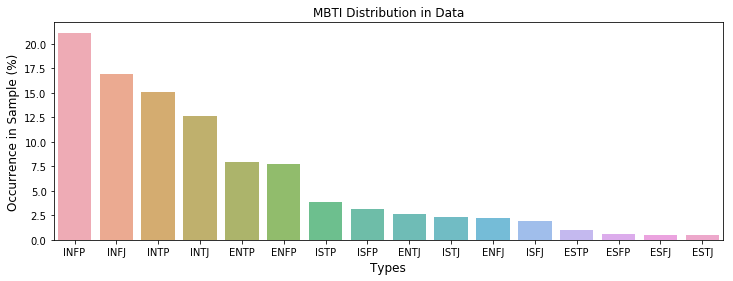

In [15]:
plt.figure(figsize=(12,4))
sns.barplot(count_types.index, count_types.values, alpha=0.8)
plt.ylabel('Occurrence in Sample (%)', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.title("MBTI Distribution in Data")
plt.show()

#### MBTI Types Distribution in General Population
https://www.myersbriggs.org/my-mbti-personality-type/my-mbti-results/how-frequent-is-my-type.htm?bhcp=1

In [16]:
genpop_types = count_types
genpop_types['ISTJ'] = 11.6
genpop_types['ISFJ'] = 13.8
genpop_types['INFJ'] = 1.5
genpop_types['INTJ'] = 2.1
genpop_types['ISTP'] = 5.4
genpop_types['ISFP'] = 8.8
genpop_types['INFP'] = 4.4
genpop_types['INTP'] = 3.3
genpop_types['ESTP'] = 4.3
genpop_types['ESFP'] = 8.5
genpop_types['ENFP'] = 8.1
genpop_types['ENTP'] = 3.2
genpop_types['ESTJ'] = 8.7
genpop_types['ESFJ'] = 12.3
genpop_types['ENFJ'] = 2.5
genpop_types['ENTJ'] = 1.8

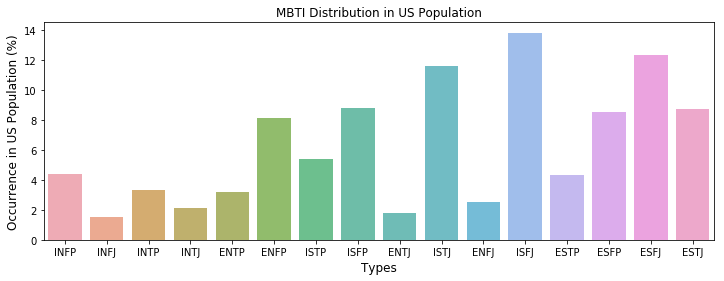

In [17]:
plt.figure(figsize=(12,4))
sns.barplot(genpop_types.index, genpop_types.values, alpha=0.8)
plt.ylabel('Occurrence in US Population (%)', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.title("MBTI Distribution in US Population")
plt.show()

#### Create 4 bit binary encoding of the class labels

In [18]:
def encode_types(row):
    t=row['type']

    I = 0
    N = 0
    T = 0
    J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('Could not identify label for I-E')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('Could not identify label for N-S')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('Could not identify label for T-F')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('Could not identify label for J-P')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

In [20]:
mbti_data_encoded = mbti_data.join(mbti_data.apply(lambda row: encode_types(row), axis=1))
mbti_data_encoded.head()

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [21]:
num_I = mbti_data_encoded['IE'].value_counts()[0]
num_E = mbti_data_encoded['IE'].value_counts()[1]
num_N = mbti_data_encoded['NS'].value_counts()[0]
num_S = mbti_data_encoded['NS'].value_counts()[1]
num_T = mbti_data_encoded['TF'].value_counts()[0]
num_F = mbti_data_encoded['TF'].value_counts()[1]
num_J = mbti_data_encoded['JP'].value_counts()[0]
num_P = mbti_data_encoded['JP'].value_counts()[1]

In [22]:
print ("Introversion (I) /  Extroversion (E):\t {} / {} ({}% / {}%)".format(num_I, num_E, round(num_I/(num_I+num_E)*100 ,2),round(num_E/(num_I+num_E)*100,2)))
print ("INtuition (N) – Sensing (S):\t {} / {} ({}% / {}%)".format(num_N, num_S, round(num_N/(num_N+num_S)*100 ,2),round(num_S/(num_N+num_S)*100,2)))
print ("Thinking (T) – Feeling (F):\t {} / {} ({}% / {}%)".format(num_T, num_F, round(num_T/(num_T+num_F)*100 ,2),round(num_F/(num_T+num_F)*100,2)))
print ("Judging (J) – Perceiving (P):\t {} / {} ({}% / {}%)".format(num_J, num_P, round(num_J/(num_J+num_P)*100 ,2),round(num_P/(num_J+num_P)*100,2)))

Introversion (I) /  Extroversion (E):	 1999 / 6676 (23.04% / 76.96%)
INtuition (N) – Sensing (S):	 1197 / 7478 (13.8% / 86.2%)
Thinking (T) – Feeling (F):	 4694 / 3981 (54.11% / 45.89%)
Judging (J) – Perceiving (P):	 5241 / 3434 (60.41% / 39.59%)


#### Pearson Feature Coorrelation

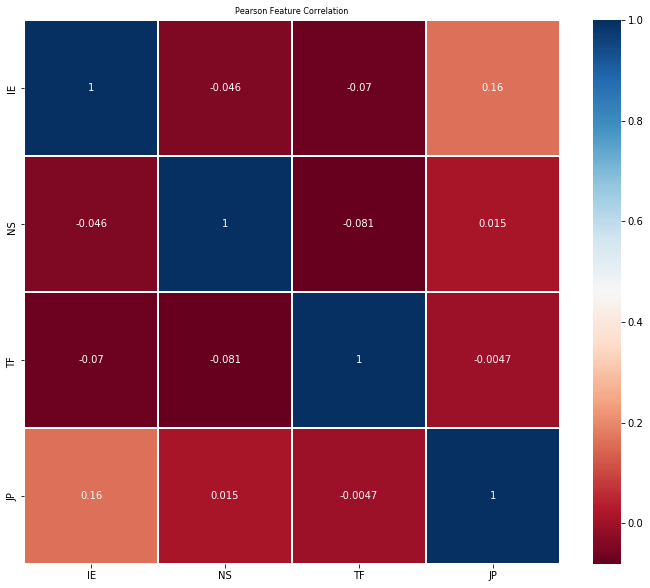

In [23]:
mbti_data_encoded[['IE','NS','TF','JP']].corr()

cmap = plt.cm.RdBu
corr = mbti_data_encoded[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Pearson Feature Correlation', size=8)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

This makes sense as we hope that each of the dimensions are unique and uncorrelated in expressing a person's psychology

In [24]:
#Function to binarize the types into simple lists instead of pandas.series
personality_binary = {'I':1, 'E':0, 'N':1,'S':0, 'T':1, 'F':0, 'J':1, 'P': 0}
binary_personality = [{1:'I', 0:'E'}, 
                      {1:'N', 0:'S'},
                      {1:'T', 0:'F'},
                      {1:'J', 0:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [personality_binary[l] for l in personality]


def translate_binary(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += binary_personality[i][l]
    return s


In [25]:
d = mbti_data_encoded.head(4)
list_personality_bin = np.array([translate_personality(p) for p in mbti_data_encoded.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[1 1 0 1]
 [0 1 1 0]
 [1 1 1 0]
 ...
 [1 1 1 0]
 [1 1 0 0]
 [1 1 0 0]]


### Data Preprocessing
* Remove urls
* Keep only words and make it lowercase
* Lemmatize each word
* Remove MBTI profiles strings. Too many appear in the posts!

In [26]:
#List of strings to remove from the corpus
unique_type_list = ['INFJ', 
                    'ENTP', 
                    'INTP', 
                    'INTJ', 
                    'ENTJ', 
                    'ENFJ', 
                    'INFP', 
                    'ENFP',
                    'ISFP', 
                    'ISTP', 
                    'ISFJ', 
                    'ISTJ', 
                    'ESTP', 
                    'ESFP', 
                    'ESTJ', 
                    'ESFJ']

unique_type_list = [x.lower() for x in unique_type_list]

# Initialize for Lemmatization
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

def pre_process_data(data, remove_stop_words = True, remove_mbti_profiles = True):
    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in stopwords.words("english")])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
            
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")

        type_labelized = translate_personality(row[1].type)
        list_personality.append(type_labelized)
        list_posts.append(temp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality


In [27]:
list_posts, list_personality  = pre_process_data(mbti_data_encoded, remove_stop_words=False)

1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows
5500 of 8675 rows
6000 of 8675 rows
6500 of 8675 rows
7000 of 8675 rows
7500 of 8675 rows
8000 of 8675 rows
8500 of 8675 rows
8675 of 8675 rows


In [28]:
pickle.dump(list_posts, open("output/list_posts.p", "wb"))
pickle.dump(list_personality, open("output/list_personality.p", "wb"))

#### CHECKPOINT - Preprocessing

In [29]:
list_posts = pickle.load(open("output/list_posts.p", "rb"))
list_personality = pickle.load(open("output/list_personality.p", "rb"))

In [30]:
print("Num posts and personalities: ",  list_posts.shape, list_personality.shape)

Num posts and personalities:  (8675,) (8675, 4)


In [31]:
list_posts[0], list_personality[0]

('  and  moment sportscenter not top ten play prank what ha been the most life changing experience in your life on repeat for most of today may the perc experience immerse you the last thing my  friend posted on his facebook before committing suicide the next day rest in peace hello  sorry to hear of your distress it s only natural for a relationship to not be perfection all the time in every moment of existence try to figure the hard time a time of growth a welcome and stuff game set match prozac wellbrutin at least thirty minute of moving your leg and i don t mean moving them while sitting in your same desk chair weed in moderation maybe try edible a a healthier alternative basically come up with three item you ve determined that each type or whichever type you want to do would more than likely use given each type cognitive function and whatnot when left by all thing in moderation sims is indeed a video game and a good one at that note a good one at that is somewhat subjective in tha

In [32]:
# Posts to a matrix of token counts
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
                             max_df=0.7,
                             min_df=0.1) 

# Learn the vocabulary dictionary and return term-document matrix
print("CountVectorizer...")
X_cnt = cntizer.fit_transform(list_posts)

# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

print("Tf-idf...")
# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()

CountVectorizer...
Tf-idf...


In [35]:
feature_names = list(enumerate(cntizer.get_feature_names()))
feature_names


[(0, 'ability'),
 (1, 'able'),
 (2, 'above'),
 (3, 'absolutely'),
 (4, 'accept'),
 (5, 'accurate'),
 (6, 'across'),
 (7, 'act'),
 (8, 'action'),
 (9, 'actual'),
 (10, 'actually'),
 (11, 'add'),
 (12, 'admit'),
 (13, 'advice'),
 (14, 'afraid'),
 (15, 'after'),
 (16, 'again'),
 (17, 'against'),
 (18, 'age'),
 (19, 'ago'),
 (20, 'agree'),
 (21, 'ah'),
 (22, 'almost'),
 (23, 'alone'),
 (24, 'along'),
 (25, 'already'),
 (26, 'although'),
 (27, 'amazing'),
 (28, 'amount'),
 (29, 'angry'),
 (30, 'animal'),
 (31, 'annoying'),
 (32, 'another'),
 (33, 'answer'),
 (34, 'anxiety'),
 (35, 'anymore'),
 (36, 'anyone'),
 (37, 'anything'),
 (38, 'anyway'),
 (39, 'apparently'),
 (40, 'appreciate'),
 (41, 'approach'),
 (42, 'area'),
 (43, 'aren'),
 (44, 'argument'),
 (45, 'around'),
 (46, 'art'),
 (47, 'ask'),
 (48, 'asked'),
 (49, 'asking'),
 (50, 'aspect'),
 (51, 'assume'),
 (52, 'attention'),
 (53, 'attracted'),
 (54, 'avatar'),
 (55, 'avoid'),
 (56, 'aware'),
 (57, 'away'),
 (58, 'awesome'),
 (59, 'a

In [36]:
X_tfidf.shape

(8675, 841)

## Classification Pipeline
### XGBoost
* X: TF-IDF representation of posts
* Y: Binarized MBTI labels

In [37]:
print("X: Posts in tf-idf representation \n* 1st row:\n%s" % X_tfidf[0])

X: Posts in tf-idf representation 
* 1st row:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.06057509 0.
 0.07691555 0.06532408 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.09881064 0.         0.         0.04756555 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.10505636 0.         0.         0.         0.0826568  0.
 0.         0.10031611 0.05024804 0.         0.         0.
 0.         0.         0.04962642 0.         0.06527165 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.       

In [38]:
type_indicators = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) – Sensing (S)", 
                   "FT: Feeling (F) - Thinking (T)", "JP: Judging (J) – Perceiving (P)"  ]

for l in range(len(type_indicators)):
    print(type_indicators[l])


IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) – Sensing (S)
FT: Feeling (F) - Thinking (T)
JP: Judging (J) – Perceiving (P)


In [39]:
print("MBTI 1st row: %s" % translate_binary(list_personality[0,:]))
print("Y: Binarized MBTI 1st row: %s" % list_personality[0,:])

MBTI 1st row: INFJ
Y: Binarized MBTI 1st row: [1 1 0 1]


In [40]:
# Posts in tf-idf representation
X = X_tfidf

# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("\n\n{} ...".format(type_indicators[l]))
    
    # Let's train type indicator individually
    Y = list_personality[:,l]
    
    print(X.shape, Y.shape)

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    
#     print("Number transactions X_train dataset: ", X_train.shape)
#     print("Number transactions y_train dataset: ", y_train.shape)
#     print("Number transactions X_test dataset: ", X_test.shape)
#     print("Number transactions y_test dataset: ", y_test.shape)

#     print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
#     print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

#     print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
#     print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

#     print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
#     print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

    # fit model on training data
    model = XGBClassifier(learning_rate=0.01,
                             n_estimators=5000,
                             max_depth=4,
                             min_child_weight=6,
                             colsample_bytree=0.8,
                             objective='binary:logistic',
                             nthread=8,
                             scale_pos_weight=1,
                             seed=7)

    model.fit(X_train_res, y_train_res)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    f1_score_measure = sklearn.metrics.f1_score(y_test, predictions)
    print(" Accuracy: {:.2f}% \t F1-Score: {:.3f}".format(accuracy * 100.0, f1_score_measure))
    
    



IE: Introversion (I) / Extroversion (E) ...
(8675, 841) (8675,)
 Accuracy: 77.30% 	 F1-Score: 0.866


NS: Intuition (N) – Sensing (S) ...
(8675, 841) (8675,)
 Accuracy: 84.95% 	 F1-Score: 0.918


FT: Feeling (F) - Thinking (T) ...
(8675, 841) (8675,)
 Accuracy: 74.54% 	 F1-Score: 0.721


JP: Judging (J) – Perceiving (P) ...
(8675, 841) (8675,)
 Accuracy: 65.63% 	 F1-Score: 0.512


### SVM

In [ ]:
# Posts in tf-idf representation
X = X_tfidf

# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("\n\n{} ...".format(type_indicators[l]))
    
    # Let's train type indicator individually
    Y = list_personality[:,l]
    
    print(X.shape, Y.shape)

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    
#     print("Number transactions X_train dataset: ", X_train.shape)
#     print("Number transactions y_train dataset: ", y_train.shape)
#     print("Number transactions X_test dataset: ", X_test.shape)
#     print("Number transactions y_test dataset: ", y_test.shape)

#     print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
#     print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

#     print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
#     print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

#     print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
#     print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

    # fit model on training data
    model = svm.SVC(gamma=0.01,
                          C=10,
                          probability=True,
                          class_weight='balanced',
                          kernel='linear')

    model.fit(X_train_res, y_train_res)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    f1_score_measure = sklearn.metrics.f1_score(y_test, predictions)
    print(" Accuracy: {:.2f}% \t F1-Score: {:.3f}".format(accuracy * 100.0, f1_score_measure))
    
    



IE: Introversion (I) / Extroversion (E) ...
(8675, 841) (8675,)
 Accuracy: 66.99% 	 F1-Score: 0.770


NS: Intuition (N) – Sensing (S) ...
(8675, 841) (8675,)
 Accuracy: 72.58% 	 F1-Score: 0.828


FT: Feeling (F) - Thinking (T) ...
(8675, 841) (8675,)
 Accuracy: 74.82% 	 F1-Score: 0.729


JP: Judging (J) – Perceiving (P) ...
(8675, 841) (8675,)


#### Hyperparamter Tuning

In [ ]:
def modelfit(alg, X, Y, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
    test_size = 0.33
    seed = 7
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=Y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy: {:.3f}".format(metrics.accuracy_score(y_test, dtrain_predictions)))
    print("AUC Score (Test): {}".format(metrics.roc_auc_score(y_test, dtrain_predprob)))
    print("F1-Score (Test): {}".format(metrics.f1_score(y_test, dtrain_predictions)))
    
    f_scores = alg.get_booster().get_fscore()
    feat_imp = pd.Series(f_scores).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
#     pickle.dump(f_scores, open("output/f_scores.p", "wb"))


In [ ]:
### PARAM SET 1
Y = list_personality[:,1]

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=7)

modelfit(xgb1, X_tfidf, Y)


In [ ]:
### PARAM SET 2
Y = list_personality[:,1]

xgb1 = XGBClassifier(
 learning_rate =0.6,
 n_estimators=300,
 max_depth=3,
 min_child_weight=7,
 gamma=0,
 subsample=0.93,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=7)

modelfit(xgb1, X_tfidf, Y)


In [ ]:
feature_scores = pickle.load(open("output/f_scores.p", "rb"))

In [ ]:
sorted_feature_scores = pd.Series(feature_scores).sort_values(ascending=False)
sorted_feature_scores

##### Top-100 Important Words for this model

In [ ]:
top_n = 100
i=0
for val in np.squeeze(np.array(sorted_feature_scores.axes)):
    print(feature_names[int(val[1:])])
    i += 1
    if(i>top_n):
        break

##### Tune __max_depth__ and __min_child_weight__

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,12,2)
}


In [ ]:
X = X_tfidf

test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


In [ ]:
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                   n_estimators=140, 
                                                   max_depth=5,
                                                   min_child_weight=1, 
                                                   gamma=0, 
                                                   subsample=0.8, 
                                                   colsample_bytree=0.8,
                                                   objective= 'binary:logistic', 
                                                   nthread=4, 
                                                   scale_pos_weight=1, 
                                                   seed=seed), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch1.fit(X_train,y_train)



In [ ]:
gsearch1.cv_results_

In [ ]:
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test2 = {
 'max_depth':range(3,5,2),
 'min_child_weight':range(1,3,2)
}


In [ ]:
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                   n_estimators=140, 
                                                   max_depth=5,
                                                   min_child_weight=1, 
                                                   gamma=0, 
                                                   subsample=0.8, 
                                                   colsample_bytree=0.8,
                                                   objective= 'binary:logistic', 
                                                   nthread=4, 
                                                   scale_pos_weight=1, 
                                                   seed=seed), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch2.fit(X_train,y_train)

In [ ]:
gsearch2.cv_results_

In [ ]:
gsearch2.best_score_, gsearch2.best_params_

#### SVM Hyperparameter Optimization

In [ ]:
def modelfitSVC(X, y, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
#     test_size = 0.33
#     seed = 7
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    Cs = [0.001, 0.01, 0.1, 1, 10]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=cv_folds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(X, label=Y)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(X_train, y_train,eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(X_test)
#     dtrain_predprob = alg.predict_proba(X_test)[:,1]
    
    
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy: {:.3f}".format(metrics.accuracy_score(y_test, dtrain_predictions)))
#     print("AUC Score (Test): {}".format(metrics.roc_auc_score(y_test, dtrain_predprob)))
#     print("F1-Score (Test): {}".format(metrics.f1_score(y_test, dtrain_predictions)))
    
#     f_scores = alg.get_booster().get_fscore()
#     feat_imp = pd.Series(f_scores).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
# #     pickle.dump(f_scores, open("output/f_scores.p", "wb"))

In [ ]:
X = X_tfidf

# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("\n\n{} ...".format(type_indicators[l]))
    
    # Let's train type indicator individually
    Y = list_personality[:,l]
    
    print(X.shape, Y.shape)

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    
#     print("Number transactions X_train dataset: ", X_train.shape)
#     print("Number transactions y_train dataset: ", y_train.shape)
#     print("Number transactions X_test dataset: ", X_test.shape)
#     print("Number transactions y_test dataset: ", y_test.shape)

#     print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
#     print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

#     print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
#     print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

#     print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
#     print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

    # fit model on training data
    result = modelfitSVC(X_train_res, y_train_res)
    print(result)

#     # make predictions for test data
#     y_pred = model.predict(X_test)
#     predictions = [round(value) for value in y_pred]
#     # evaluate predictions
#     accuracy = accuracy_score(y_test, predictions)
#     f1_score_measure = sklearn.metrics.f1_score(y_test, predictions)
#     print(" Accuracy: {:.2f}% \t F1-Score: {:.3f}".format(accuracy * 100.0, f1_score_measure))